In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [4]:
def bonos_dbAlgebra(n,cn):

    niu_data = pd.DataFrame()

    bonos = "SELECT TOP ("+ str(n) +") Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, NemotecnicoBono AS Nemotecnico, RiesgoInt FROM (SELECT * FROM (SELECT Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, Nemotecnico AS NemotecnicoBono FROM [dbAlgebra].[dbo].[TdNemoRF]) AS bono JOIN (SELECT * FROM [dbPortFolio].[dbo].[TdPlanvitalCartera]) AS planvital ON bono.FechaEmision > '20190101' AND bono.NemotecnicoBono = planvital.Nemotecnico) AS A JOIN (SELECT DISTINCT Nemotecnico, RiesgoLVA AS RiesgoInt FROM [dbAlgebra].[dbo].[TdRiesgoLva]) AS B ON A.NemotecnicoBono = B.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)

    moneda = []
    base1 = []
    base2 = []
    tabla = []
    fechaemi = []
    nemotecnico = []
    riesgo = []
    for i in range(np.size(bonos, 0)):

        if bonos["Nemotecnico"][i] in nemotecnico: continue

        if bonos["RiesgoInt"][i] in riesgo : continue

        moneda.append(bonos["Moneda"][i])
        base1.append(bonos["Base1"][i])
        base2.append(bonos["Base2"][i])
        tabla.append(bonos["TablaDesarrollo"][i])
        fechaemi.append(bonos["FechaEmision"][i])
        nemotecnico.append(bonos["Nemotecnico"][i])
        riesgo.append(bonos["RiesgoInt"][i])

    niu_data["Moneda"] = moneda
    niu_data["Base1"] = base1
    niu_data["Base2"] = base2
    niu_data["TablaDesarrollo"] = tabla
    niu_data["FechaEmision"] = fechaemi
    niu_data["Nemotecnico"] = nemotecnico
    niu_data["RiesgoInt"] = riesgo


    return niu_data

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {-1: "AAA", 1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
bonos = ajustes(bonos_dbAlgebra(500,cn))
bonos

,Moneda,Base1,Base2,TablaDesarrollo,FechaEmision,Nemotecnico,RiesgoInt,Convencion,Riesgo
0,UF,ACT,365,"1#01-08-2019#1,25#0#100#1,25|2#01-02-2020#1,25...",2019-02-01,BBIC750219,3,ACT/365,AA
1,UF,ACT,365,"1#01-03-2020#0,3245#0#100#0,3245|2#01-09-2020#...",2019-09-01,BCSSA-C,2,ACT/365,AA
2,UF,ACT,365,"1#01-09-2019#1,3163#0#100#1,3163|2#01-03-2020#...",2019-03-01,BFFCC-AD,1,ACT/365,AAA
3,UF,ACT,365,"1#30-10-2019#1,094#0#100#1,094|2#30-04-2020#1,...",2019-04-30,BVIAS-A,4,ACT/365,AA
4,UF,ACT,365,"1#01-12-2019#0,8464#0#100#0,8464|2#01-06-2020#...",2019-06-01,BCMPC-O,-1,ACT/365,AAA
5,UF,ACT,365,"1#15-10-2019#1,7841#0#100#1,7841|2#15-04-2020#...",2019-04-15,BLATM-E,8,ACT/365,BBB


In [7]:
bonos["Riesgo"].values

array(['AA', 'AA', 'AAA', 'AA', 'AAA', 'BBB'], dtype=object)

In [8]:
derivados = derivados_dBDerivados(1, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

C:\Users\Lenovo\Documents\Universidad\Practica\Intento\Cartera\DerivadosTipos\DerivadosSCC.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_cartera.MonedaActivo[0] = "CLP"


,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [9]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "DE000DWS2D90", "ANTARCHILE"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)
acciones


,Moneda,Nombre,Nemotecnico,Inversion,Historico
0,CLP,AESGENER,AESGENER,1.711040e+09,"[[0, 0.0025957870479299534, -0.007433469137058..."
1,CLP,AGUAS-A,AGUAS-A,1.531281e+07,"[[0, 0.003305297208302039, 0.03566773260328181..."
2,CLP,ANDINA-A,ANDINA-A,1.492768e+08,"[[0, 0.00034804011961498776, 0.018505998119275..."
3,CLP,ANDINA-B,ANDINA-B,1.073699e+09,"[[0, 0.005746838657845234, 0.0175731917247771,..."
4,CLP,DE000DWS2D90,DE000DWS2D90,1.194112e+10,"[[0, -0.011984448831005957, -0.025391621016988..."
5,CLP,ANTARCHILE,ANTARCHILE,1.511532e+08,"[[0, 0.009876696995043567, 0.00310408270978682..."


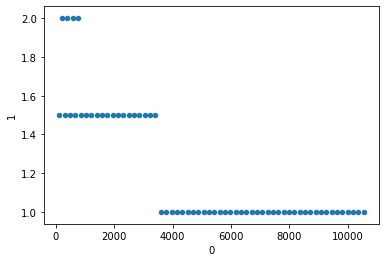

In [10]:
cartera = Cartera(acciones, bonos.head(3), derivados, "CLP", datetime.date(2019, 10, 14), cn)

In [11]:
cartera.get_diccionario_niveles()

{1: {('Renta Variable Nacional Acciones',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.51153165e+08]),
  ('Renta Variable Extranjera',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.19411228e+10, 0.00000000e+00]),
  ('Renta Fija Nacional ',
   'Bono',
   'AA'): array([1.04317667e+00, 7.86202169e-01, 1.22184769e-01, 5.09496637e-01,
         6.01189497e-02, 3.06847651e-01, 3.48177883e-02, 1.74493423e-01,
         8.58347420e-02, 2.77874754e-02, 1.23881087e-02, 2.95795266e-02,
         1.22251476e-02, 4.61210334e-03, 2.07410743e-03, 1.01985428e-03,
         5.16222765e-04, 2.55932209e-04, 1.29642292e-04, 6.42293931e-05,
         3.25604916e-05, 1.61795135e-05, 9.47645977e-05, 1.79067323e-04,
         1.56535809e-05, 6.12400141e-05, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00,

In [12]:
print(cartera.get_bonos()[0].get_historicos())

    UF#123#AA  UF#209#AA  UF#304#AA  UF#390#AA  UF#484#AA  UF#569#AA  \
0    1.018823   1.032194   1.047168   1.060902   1.076093   1.090006   
1    1.018671   1.031932   1.046782   1.060410   1.075507   1.089345   
2    1.018438   1.031531   1.046189   1.059643   1.074555   1.088225   
3    1.018684   1.031955   1.046815   1.060453   1.075562   1.089409   
4    1.018696   1.031975   1.046845   1.060491   1.075610   1.089467   
5    0.996005   0.992346   0.987278   0.981593   0.973994   0.965651   
6    0.995218   0.989641   0.980287   0.970483   0.963516   0.957263   
7    0.995306   0.989958   0.981152   0.971986   0.965321   0.959323   
8    0.996262   0.993155   0.989183   0.985042   0.979872   0.974548   
9    0.996115   0.992698   0.988117   0.983132   0.976650   0.969716   
10   0.996309   0.993300   0.989512   0.985624   0.980834   0.975967   
11   0.996165   0.992855   0.988488   0.983802   0.977790   0.971439   
12   0.995614   0.991041   0.984020   0.976940   0.971470   0.96

In [13]:
print(cartera.get_retornos_totales())

      CLP#123#AA  CLP#209#AA  CLP#304#AA  CLP#390#AA  CLP#484#AA  CLP#569#AA  \
0   0.000000e+00    0.000000    0.000000    0.000000    0.000000    0.000000   
1  -5.232945e-05   -0.000156   -0.000272   -0.000367   -0.000448   -0.000510   
2  -1.325953e-04   -0.000293   -0.000470   -0.000627   -0.000789   -0.000932   
3   5.321347e-04    0.000701    0.000888    0.001054    0.001226    0.001378   
4   1.079501e-04    0.000116    0.000125    0.000133    0.000141    0.000149   
5  -2.242939e-02   -0.039061   -0.058488   -0.077214   -0.099141   -0.120545   
6  -6.936356e-04   -0.002632   -0.007009   -0.011286   -0.010720   -0.008627   
7   1.847702e-04    0.000417    0.000978    0.001644    0.001969    0.002246   
8   1.249576e-03    0.003515    0.008442    0.013633    0.015251    0.016035   
9  -5.039298e-05   -0.000364   -0.000981   -0.001845   -0.003197   -0.004873   
10  2.905408e-04    0.000703    0.001507    0.002628    0.004371    0.006522   
11 -4.665214e-05   -0.000350   -0.000939

In [14]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.008533227854007074


In [15]:
cartera.get_covarianza()

,CLP#123#AA,CLP#209#AA,CLP#304#AA,CLP#390#AA,CLP#484#AA,CLP#569#AA,CLP#664#AA,CLP#750#AA,CLP#844#AA,CLP#1024#AA,...,CLP#9864,CLP#10045,CLP#10224,CLP#10406,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#123#AA,0.000010,0.000018,0.000029,0.000040,0.000049,0.000057,0.000066,0.000073,0.000075,0.000075,...,4.811146e-07,4.899112e-07,4.986107e-07,5.074559e-07,0.000006,-0.000010,0.000011,0.000008,-0.000005,-0.000006
CLP#209#AA,0.000018,0.000033,0.000054,0.000074,0.000091,0.000106,0.000122,0.000132,0.000136,0.000135,...,6.776670e-07,6.900354e-07,7.022671e-07,7.147039e-07,0.000011,-0.000017,0.000020,0.000015,-0.000010,-0.000012
CLP#304#AA,0.000029,0.000054,0.000089,0.000123,0.000150,0.000172,0.000196,0.000211,0.000216,0.000211,...,7.789864e-07,7.931285e-07,8.071143e-07,8.213344e-07,0.000015,-0.000028,0.000034,0.000026,-0.000014,-0.000020
CLP#390#AA,0.000040,0.000074,0.000123,0.000171,0.000207,0.000237,0.000268,0.000288,0.000294,0.000286,...,1.040298e-06,1.059165e-06,1.077824e-06,1.096795e-06,0.000020,-0.000038,0.000048,0.000036,-0.000019,-0.000028
CLP#484#AA,0.000049,0.000091,0.000150,0.000207,0.000252,0.000291,0.000332,0.000359,0.000368,0.000361,...,2.145639e-06,2.184852e-06,2.223632e-06,2.263062e-06,0.000028,-0.000047,0.000059,0.000043,-0.000025,-0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,-0.000010,-0.000017,-0.000028,-0.000038,-0.000047,-0.000056,-0.000067,-0.000074,-0.000077,-0.000080,...,-1.715995e-05,-1.747448e-05,-1.778553e-05,-1.810180e-05,-0.000012,0.000100,0.000039,0.000058,0.000016,0.000037
ANDINA-A,0.000011,0.000020,0.000034,0.000048,0.000059,0.000068,0.000078,0.000085,0.000086,0.000083,...,6.637003e-05,6.758837e-05,6.879326e-05,7.001833e-05,0.000015,0.000039,0.000418,0.000084,0.000051,0.000085
ANDINA-B,0.000008,0.000015,0.000026,0.000036,0.000043,0.000048,0.000052,0.000052,0.000045,0.000022,...,-4.318239e-05,-4.397454e-05,-4.475794e-05,-4.555447e-05,-0.000003,0.000058,0.000084,0.000433,0.000008,0.000084
DE000DWS2D90,-0.000005,-0.000010,-0.000014,-0.000019,-0.000025,-0.000032,-0.000040,-0.000045,-0.000046,-0.000045,...,3.078507e-05,3.135070e-05,3.191009e-05,3.247885e-05,-0.000006,0.000016,0.000051,0.000008,0.000063,0.000009


In [16]:
cartera.get_correlacion()

,CLP#123#AA,CLP#209#AA,CLP#304#AA,CLP#390#AA,CLP#484#AA,CLP#569#AA,CLP#664#AA,CLP#750#AA,CLP#844#AA,CLP#1024#AA,...,CLP#9864,CLP#10045,CLP#10224,CLP#10406,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#123#AA,1.000000,0.995708,0.979061,0.968524,0.984064,0.993620,0.995531,0.989070,0.978508,0.917653,...,0.010844,0.010843,0.010843,0.010842,0.149310,-0.306250,0.169688,0.118492,-0.218914,-0.160669
CLP#209#AA,0.995708,1.000000,0.993634,0.987280,0.996032,0.998354,0.990888,0.977266,0.963015,0.893899,...,0.008282,0.008281,0.008281,0.008280,0.138052,-0.302175,0.173654,0.127220,-0.207976,-0.168326
CLP#304#AA,0.979061,0.993634,1.000000,0.998887,0.999064,0.992341,0.973278,0.950863,0.932077,0.853258,...,0.005811,0.005810,0.005809,0.005808,0.120495,-0.293942,0.176878,0.132589,-0.190152,-0.174746
CLP#390#AA,0.968524,0.987280,0.998887,1.000000,0.996796,0.986530,0.962959,0.937107,0.916444,0.833702,...,0.005602,0.005600,0.005599,0.005598,0.113314,-0.289929,0.178634,0.133663,-0.182689,-0.176435
CLP#484#AA,0.984064,0.996032,0.999064,0.996796,1.000000,0.996453,0.981438,0.961932,0.944201,0.867388,...,0.009511,0.009510,0.009509,0.009509,0.129694,-0.298870,0.180515,0.130130,-0.199326,-0.172946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,-0.306250,-0.302175,-0.293942,-0.289929,-0.298870,-0.306346,-0.312920,-0.315859,-0.315853,-0.303617,...,-0.120891,-0.120889,-0.120887,-0.120885,-0.088274,1.000000,0.188988,0.277994,0.195585,0.303122
ANDINA-A,0.169688,0.173654,0.176878,0.178634,0.180515,0.181188,0.180083,0.177145,0.172580,0.155496,...,0.228667,0.228669,0.228672,0.228674,0.056380,0.188988,1.000000,0.197562,0.311225,0.338087
ANDINA-B,0.118492,0.127220,0.132589,0.133663,0.130130,0.125267,0.117494,0.106335,0.087685,0.040229,...,-0.146166,-0.146166,-0.146166,-0.146166,-0.010407,0.277994,0.197562,1.000000,0.049990,0.327175
DE000DWS2D90,-0.218914,-0.207976,-0.190152,-0.182689,-0.199326,-0.215498,-0.234185,-0.243576,-0.237559,-0.214156,...,0.272504,0.272512,0.272519,0.272526,-0.060160,0.195585,0.311225,0.049990,1.000000,0.093734


In [17]:
cartera.get_volatilidad_niveles()

{1: {('Renta Variable Nacional Acciones', 'Accion'): 0.012318889593453,
  ('Renta Variable Extranjera', 'Accion'): 0.00795634184685601,
  ('Renta Fija Nacional ', 'Bono', 'AA'): 0.007200642656663286,
  ('Renta Fija Nacional ', 'Bono', 'AAA'): 0.032712792480836445,
  ('Derivados', 'Derivado'): 0.000589004157788914},
 2: {('Acciones Electricas', 'Accion'): 0.013447928815038571,
  ('Acciones Servicios', 'Accion'): 0.00999697675731327,
  ('Acciones Industrial', 'Accion'): 0.02080684545966357,
  ('Equities Europe', 'Accion'): 0.00795634184685601,
  ('Acciones Recursos Naturales', 'Accion'): 0.012318889593453,
  ('Bonos Financieros', 'Bono', 'AA'): 0.0074252980054157775,
  ('Bonos Corporativos', 'Bono', 'AAA'): 0.032664838260260814,
  ('Derivados FWD Inversión', 'Derivado'): 0.0005890041577911218}}

In [18]:
cartera.var_porcentual_dinero()

0.06478943118838013

In [19]:
cartera.calcular_var_RI()

,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE,BBIC750219,BCSSA-C,BFFCC-AD,BCINO UF 200709_A
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.020521,0.020475,0.020475,0.020515,0.010184,0.020476,0.020475,0.020475,0.020475,0.020471
2,0.042962,0.043089,0.043092,0.043207,0.021949,0.043090,0.043089,0.043089,0.043089,0.043088
3,0.008184,0.008209,0.008208,0.008158,0.004864,0.008210,0.008209,0.008209,0.008209,0.008209
4,0.022257,0.022342,0.022340,0.022237,0.013538,0.022343,0.022342,0.022342,0.022342,0.022343
5,0.003210,0.003309,0.003309,0.003291,0.002963,0.003307,0.003309,0.003309,0.003309,0.003307
6,0.002386,0.002309,0.002304,0.002349,0.000837,0.002307,0.002309,0.002309,0.002309,0.002307
7,0.006844,0.007041,0.007038,0.007016,0.005628,0.007042,0.007041,0.007041,0.007041,0.007041
8,0.003605,0.003648,0.003647,0.003703,0.001743,0.003647,0.003648,0.003648,0.003648,0.003648
9,0.019447,0.019433,0.019433,0.019414,0.010313,0.019431,0.019433,0.019433,0.019433,0.019434


In [20]:
cartera.calcular_var_RI_M()

,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE,BBIC750219,BCSSA-C,BFFCC-AD,BCINO UF 200709_A
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.047468,2.047513,2.047513,2.047473,2.057805,2.047512,2.047513,2.047513,2.047513,2.047518
2,4.309040,4.308913,4.308911,4.308795,4.330053,4.308913,4.308913,4.308913,4.308913,4.308915
3,0.820875,0.820850,0.820851,0.820901,0.824195,0.820849,0.820850,0.820850,0.820850,0.820850
4,2.234335,2.234249,2.234251,2.234355,2.243053,2.234248,2.234249,2.234249,2.234249,2.234248
5,0.331017,0.330917,0.330917,0.330936,0.331263,0.330920,0.330917,0.330917,0.330917,0.330919
6,0.230781,0.230858,0.230863,0.230818,0.232330,0.230860,0.230858,0.230858,0.230858,0.230860
7,0.704333,0.704136,0.704139,0.704162,0.705549,0.704136,0.704136,0.704136,0.704136,0.704136
8,0.364834,0.364791,0.364791,0.364736,0.366696,0.364791,0.364791,0.364791,0.364791,0.364791
9,1.943281,1.943295,1.943295,1.943314,1.952415,1.943297,1.943295,1.943295,1.943295,1.943294
